In [70]:
from langchain.vectorstores import Qdrant
from qdrant_client import QdrantClient
from langchain.embeddings import OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain import LLMChain
from langchain.llms import OpenAI
import tiktoken
import fitz
import re
import os
import numpy as np
from glob import glob
import math
from unicodedata import normalize
from langchain.text_splitter import RecursiveCharacterTextSplitter
import MeCab
from langchain.memory import ConversationBufferWindowMemory
from langchain.schema import Document
from langchain.chat_models import ChatOpenAI
COLLECTION_NAME = "category"

## qdrant接続

In [3]:
HOST = 'qdrant'
PORT = 6333
client = QdrantClient(host=HOST, port=PORT)
db = Qdrant(
        client=client,
        collection_name=COLLECTION_NAME, 
        embeddings=OpenAIEmbeddings()
    )

In [54]:
## データ挿入
def insert_data(documents,embeddings,host,port,collection_name):
    qdrant = Qdrant.from_documents(documents, embeddings,host=host,port=port, collection_name= collection_name)

In [88]:
def data_get(data_dir_path,category):
    mean_category_data = []
    count = client.count(COLLECTION_NAME).count
    data = client.scroll(COLLECTION_NAME,limit=count,with_vectors=True)
    category_vector = [data[0][i].vector for i in range(count) if data[0][i].payload["metadata"]["category"] == category]
    for file_path in glob(data_dir_path+"/*.pdf"):
        filename = os.path.splitext(os.path.basename(file_path))[0]
        mean_category_data.append(np.mean([data[0][i].vector for i in range(count) if data[0][i].payload["metadata"]["filename"] == filename],axis=0))
    return category_vector,mean_category_data

In [43]:
count = client.count(COLLECTION_NAME)
data = client.scroll(COLLECTION_NAME,limit=100,with_vectors=True)
data[0][0].payload["page_content"]

'つまり、所有権は資産への排他的な支配を行う,物権(有体物)に対する処分する権利、使用する権利、収益を得る権利を含む統合的な権利であるので、無体物(デジタルデータなど)に対する所有の法的根拠はない\n5\n2NFTの構造における資産と所有者の関係NFTは、ブロックチェーン上にDeedを実現する手段であり、所有者という概念はNFTの属性データの一つに過ぎない\n5\n3ERC721ERC721は、EthereumブロックチェーンのNFTの標準仕様の一つである\n主キーは、ERC721で実現するDeedを識別するIDとしている\n参照する資産の所有関係の証明意図したデータERC721Metadataと呼ばれるものを参照する\n図3ERC7215\n4NFTの処分NFTの処分は、資産(NFT)を所有する主体が,他者に所有権を渡すことである\n所有者は、その主体が所持するワレットと呼ばれるソフトウェアの公開鍵と秘密鍵のペアによって識別される\n図4NFTの処分5\n5NFTの使用NFT自体には排他的な使用権は存在しない\nNFTの機能は本質的にそれが参照する対象の所有権の証書に過ぎない'

## PDF読み込み

In [58]:
def pdf_reader(file_path):
    doc = fitz.open(file_path)
    text_data = ""
    for page in range(len(doc)):
        page_data = doc[page]
        text_data += page_data.get_text() +"\n"
    return text_data

def normalize_text(text_data,remove_str="\u3000"):
    clean_text = normalize('NFKC', text_data)
    clean_text = re.sub(remove_str, r'', clean_text)
    return clean_text

def chunk_split(text_data,chunk_num=500,split_str="。.．"):
    split_word = "["+split_str+"]"
    text_data = text_data.replace("\n","")
    text_data = re.sub(split_word , '\n', text_data)
    text_splitter = RecursiveCharacterTextSplitter(
    separators = ["\n",""],
    chunk_size = chunk_num,
    chunk_overlap = 0
    )
    return text_splitter.split_text(text_data)

def text_to_documents(text_list,metadata):
    return [Document(page_content = data,metadata = metadata) for data in text_list]
    

## ベクトル化

In [59]:
for dir_path in glob("./workspace/category/*"):
    category = os.path.basename(dir_path)
    for file_path in glob(dir_path+"/*.pdf"):
        filename = os.path.splitext(os.path.basename(file_path))[0]
        text = pdf_reader(file_path)
        clean_text = normalize_text(text,remove_str="[\u3000 ]")
        split_text = chunk_split(clean_text,chunk_num=500)    
        documents = text_to_documents(split_text,
                                      metadata={"category":category,"filename":filename})
        insert_data(documents,
                    embeddings = OpenAIEmbeddings(),
                    host=HOST,
                    port=PORT,
                    collection_name=COLLECTION_NAME)

## ベクトル可視化

In [89]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import japanize_matplotlib

model_pca = PCA(n_components=2)
category_list = [os.path.basename(dir_path) for dir_path in glob("./workspace/category/*")]
label_list,mean_label_list = [],[]
mean_vector_list,vector_list = [],[]
for d,dir_path in enumerate(glob("./workspace/category/*")):
    category = os.path.basename(dir_path)
    category_vector_list,category_mean_vector_list = data_get(dir_path,category)
    vector_list += category_vector_list
    mean_vector_list += category_mean_vector_list
    label_list += [d for _ in range(len(category_vector_list))]
    mean_label_list += [d for _ in range(len(category_mean_vector_list))]


In [90]:
for i in range(5):
    print(len([label for label in label_list if label == i]))

340
483
273
552
471


### 単体のベクトル

In [102]:
model_pca = PCA(n_components=2)
pca_data = model_pca.fit_transform(vector_list)

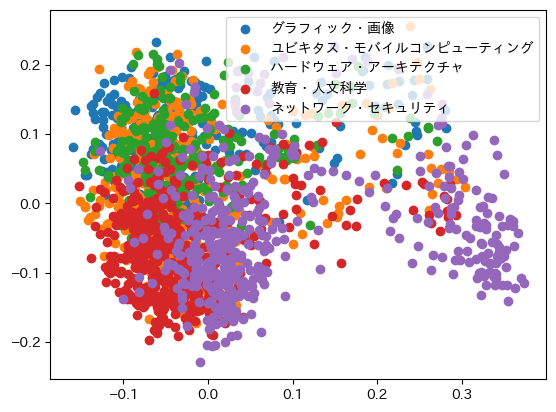

In [103]:
for i in range(5):
    data = [pca for pca,label in zip(pca_data,label_list) if label == i]
    x,y = [p[0] for p in data],[p[1] for p in data]
    plt.scatter(x,y, label=category_list[i])
plt.legend()



In [104]:
model_pca.explained_variance_ratio_

array([0.05036449, 0.04071667])

### 代表ベクトル

In [105]:
model_pca = PCA(n_components=2)
pca_data = model_pca.fit_transform(mean_vector_list)

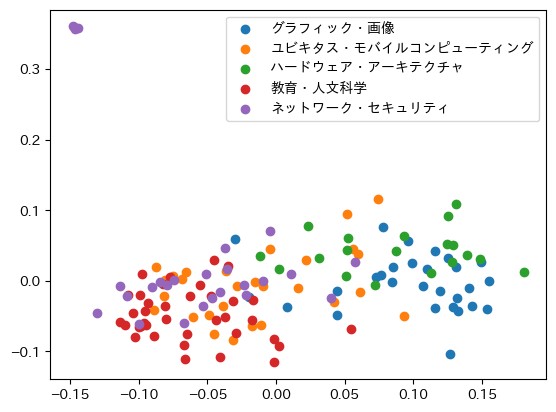

In [106]:
for i in range(5):
    data = [pca for pca,label in zip(pca_data,mean_label_list) if label == i]
    x,y = [p[0] for p in data],[p[1] for p in data]
    plt.scatter(x,y, label=category_list[i])
plt.legend()

In [107]:
model_pca.explained_variance_ratio_

array([0.08061487, 0.06597629])

### 寄与率

In [120]:

model_pca = PCA()
pca_data = model_pca.fit(mean_vector_list)

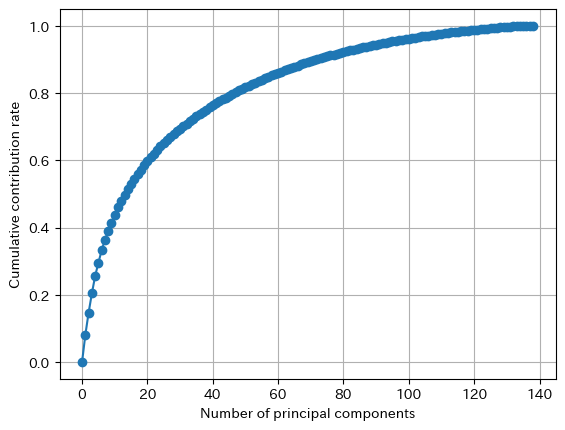

In [121]:
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca_data.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

In [123]:
model_pca = PCA()
pca_data = model_pca.fit_transform(mean_vector_list)
print(len(pca_data[0]))

138


## クラスタリング

In [113]:
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
category_list

['グラフィック・画像',
 'ユビキタス・モバイルコンピューティング',
 'ハードウェア・アーキテクチャ',
 '教育・人文科学',
 'ネットワーク・セキュリティ']

### 基本ベクトル

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

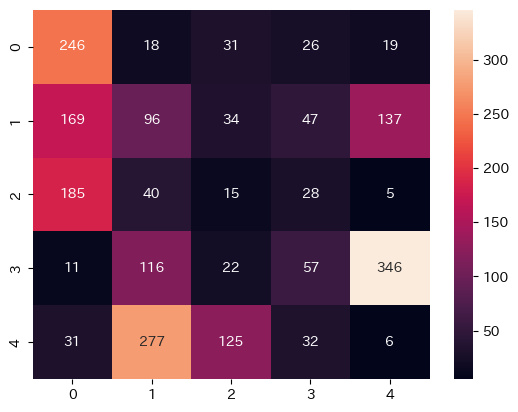

In [111]:
kmeans = KMeans(n_clusters=5, random_state=0)
cluster_pred = kmeans.fit_predict(vector_list)
result = [[0 for i in range(5)] for j in range(5)]
for label,pred in zip(label_list,cluster_pred):
    result[label][pred] += 1
sns.heatmap(result, annot=True,fmt="d")


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

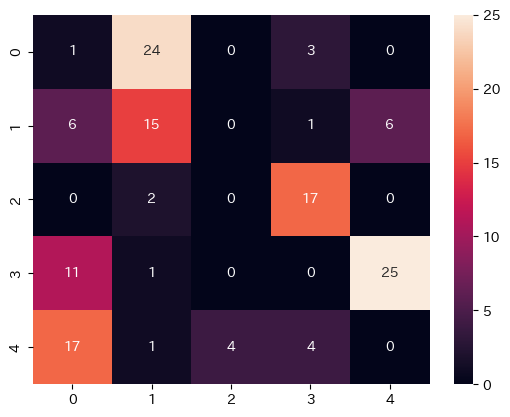

In [128]:
kmeans = KMeans(n_clusters=5, random_state=0)
cluster_pred = kmeans.fit_predict(mean_vector_list)
result = [[0 for i in range(5)] for j in range(5)]
for label,pred in zip(mean_label_list,cluster_pred):
    result[label][pred] += 1
sns.heatmap(result, annot=True,fmt="d")


## 既存のシステム

In [21]:
llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
memory = ConversationBufferWindowMemory(memory_key="chat_history",k=3)
def documents_search(db,query,top_k=3,filter=None,border=0.7):
    docs = db.similarity_search_with_score(query=query, k=top_k,filter=filter)
    print([doc for doc,score in docs])
    return [doc.page_content for doc,score in docs if score > border],[[doc.metadata["category"],doc.metadata["filename"]] for doc,score in docs if score > border],[score for doc,score in docs if score > border]

def create_template(relate_info):
    input_val = ["chat_history","query"]
    template = "{chat_history}\n質問：{query}\n関連情報\n"
    for i,info in enumerate(relate_info):
        template += f"{i+1}.{info}\n"
    template += "解答："
    return PromptTemplate(input_variables=input_val,template=template)

def save_memory(memory,query,response):
    memory.chat_memory.add_user_message(query)
    memory.chat_memory.add_ai_message(response)
    
def chat(query,llm,memory,db,relate_num=3,filter=None):
    enc = tiktoken.get_encoding("gpt2")
    related_data,category_data,score_data = documents_search(db,query,top_k=relate_num,filter=filter)
    if related_data == [] or len(enc.encode("".join(related_data))) > 4000:
        response = "すみません。答えられません。"
        return response,related_data
    template = create_template(related_data)
    llm_chain = LLMChain(
    llm=llm,
    prompt=template,
    memory=memory,
    verbose=True,
    )
    response = llm_chain(query)["text"]
    save_memory(memory,query,response)
    return response,related_data,category_data

In [22]:
query = "グラフィック・画像に関する研究についてどのようなものがありますか？論文の執筆者とともに教えてください"
result,relate_data,category_data = chat(query,llm,memory,db,relate_num=5)
result

[Document(page_content='本稿では,ワークシートに付随す†香川大学大学院創発科学研究科GraduateSchoolofScienceforCreativeEmergence,KagawaUniversity‡香川大学創造工学部FacultyofEngineeringandDesign,KagawaUniversityFIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved\n281N-020第4分冊る問題のうち,以下の2つの条件を満たす場合,意見を問う問題と仮定する\n・解答方法が長文・解答例が1つでない人手で940件のワークシートを確認した結果,439件(47\n0%)のワークシートに意見を問う問題が付随していることを確認した\n静岡新聞のNIEワークシートは,PDFファイルで公開されているため,記事本文のテキストデータを取得するにはコストがかかる', metadata={'category': '教育・人文科学', 'filename': 'N-020'}), Document(page_content='本実験システムは、フロントエン図1システムの概念図FIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved\n95CN-003第4分冊ドを表示するHTMLファイルとJavaScriptファイルを個人のコンピュータ上で動作させることで、誰でも利用可能である\nデータ登録時のデータの流れを図2、3に示す\n1件のデータを登録する際、資料所有者によってWebページのフォームに入力されたデータは、JavaScriptのコードによって処理され、スマートコントラクトへ送られる\nスマートコントラクトはデータを受け取り、イベントを生成する\nTh

'グラフィック・画像に関する研究には、以下のようなものがあります。\n\n1. 香川大学大学院創発科学研究科の研究者による研究\n2. 香川大学創造工学部の研究者による研究\n3. 高知大学大学院総合人間自然科学研究科の研究者による研究\n4. 高知大学理工学部の研究者による研究\n5. 高知大学教育研究部自然科学系理工学部門の研究者による研究\n6. 岩手県立大学ソフトウェア情報学研究科の研究者による研究\n\nただし、具体的な論文の執筆者までは情報が提供されていないため、詳細な情報はわかりません。'

In [23]:
print(result)

グラフィック・画像に関する研究には、以下のようなものがあります。

1. 香川大学大学院創発科学研究科の研究者による研究
2. 香川大学創造工学部の研究者による研究
3. 高知大学大学院総合人間自然科学研究科の研究者による研究
4. 高知大学理工学部の研究者による研究
5. 高知大学教育研究部自然科学系理工学部門の研究者による研究
6. 岩手県立大学ソフトウェア情報学研究科の研究者による研究

ただし、具体的な論文の執筆者までは情報が提供されていないため、詳細な情報はわかりません。


In [24]:
for re_data,ca_data in zip(relate_data,category_data):
    print(re_data)
    print(ca_data)
    print()

本稿では,ワークシートに付随す†香川大学大学院創発科学研究科GraduateSchoolofScienceforCreativeEmergence,KagawaUniversity‡香川大学創造工学部FacultyofEngineeringandDesign,KagawaUniversityFIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved
281N-020第4分冊る問題のうち,以下の2つの条件を満たす場合,意見を問う問題と仮定する
・解答方法が長文・解答例が1つでない人手で940件のワークシートを確認した結果,439件(47
0%)のワークシートに意見を問う問題が付随していることを確認した
静岡新聞のNIEワークシートは,PDFファイルで公開されているため,記事本文のテキストデータを取得するにはコストがかかる
['教育・人文科学', 'N-020']

本実験システムは、フロントエン図1システムの概念図FIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved
95CN-003第4分冊ドを表示するHTMLファイルとJavaScriptファイルを個人のコンピュータ上で動作させることで、誰でも利用可能である
データ登録時のデータの流れを図2、3に示す
1件のデータを登録する際、資料所有者によってWebページのフォームに入力されたデータは、JavaScriptのコードによって処理され、スマートコントラクトへ送られる
スマートコントラクトはデータを受け取り、イベントを生成する
TheGraphはそのイベントを検知し、どのようなデータが保存されたかを取得し、データをインデクシングして保存する
['教育・人文科学', 'CN-003']

•出力される各作品に対して

In [29]:
docs = documents_search(db,query,top_k=5)

[Document(page_content='本稿では,ワークシートに付随す†香川大学大学院創発科学研究科GraduateSchoolofScienceforCreativeEmergence,KagawaUniversity‡香川大学創造工学部FacultyofEngineeringandDesign,KagawaUniversityFIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved\n281N-020第4分冊る問題のうち,以下の2つの条件を満たす場合,意見を問う問題と仮定する\n・解答方法が長文・解答例が1つでない人手で940件のワークシートを確認した結果,439件(47\n0%)のワークシートに意見を問う問題が付随していることを確認した\n静岡新聞のNIEワークシートは,PDFファイルで公開されているため,記事本文のテキストデータを取得するにはコストがかかる', metadata={'category': '教育・人文科学', 'filename': 'N-020'}), Document(page_content='本実験システムは、フロントエン図1システムの概念図FIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved\n95CN-003第4分冊ドを表示するHTMLファイルとJavaScriptファイルを個人のコンピュータ上で動作させることで、誰でも利用可能である\nデータ登録時のデータの流れを図2、3に示す\n1件のデータを登録する際、資料所有者によってWebページのフォームに入力されたデータは、JavaScriptのコードによって処理され、スマートコントラクトへ送られる\nスマートコントラクトはデータを受け取り、イベントを生成する\nTh

In [30]:
docs

(['本稿では,ワークシートに付随す†香川大学大学院創発科学研究科GraduateSchoolofScienceforCreativeEmergence,KagawaUniversity‡香川大学創造工学部FacultyofEngineeringandDesign,KagawaUniversityFIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved\n281N-020第4分冊る問題のうち,以下の2つの条件を満たす場合,意見を問う問題と仮定する\n・解答方法が長文・解答例が1つでない人手で940件のワークシートを確認した結果,439件(47\n0%)のワークシートに意見を問う問題が付随していることを確認した\n静岡新聞のNIEワークシートは,PDFファイルで公開されているため,記事本文のテキストデータを取得するにはコストがかかる',
  '本実験システムは、フロントエン図1システムの概念図FIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved\n95CN-003第4分冊ドを表示するHTMLファイルとJavaScriptファイルを個人のコンピュータ上で動作させることで、誰でも利用可能である\nデータ登録時のデータの流れを図2、3に示す\n1件のデータを登録する際、資料所有者によってWebページのフォームに入力されたデータは、JavaScriptのコードによって処理され、スマートコントラクトへ送られる\nスマートコントラクトはデータを受け取り、イベントを生成する\nTheGraphはそのイベントを検知し、どのようなデータが保存されたかを取得し、データをインデクシングして保存する',
  '•出力される各作品に対して回答する項目項目1この作品を知っていますか?項

## Retriverの活用

In [27]:
retriever = db.as_retriever(search_kwargs={"k": 5})
docs = retriever.get_relevant_documents(query)

In [28]:
docs

[Document(page_content='本稿では,ワークシートに付随す†香川大学大学院創発科学研究科GraduateSchoolofScienceforCreativeEmergence,KagawaUniversity‡香川大学創造工学部FacultyofEngineeringandDesign,KagawaUniversityFIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved\n281N-020第4分冊る問題のうち,以下の2つの条件を満たす場合,意見を問う問題と仮定する\n・解答方法が長文・解答例が1つでない人手で940件のワークシートを確認した結果,439件(47\n0%)のワークシートに意見を問う問題が付随していることを確認した\n静岡新聞のNIEワークシートは,PDFファイルで公開されているため,記事本文のテキストデータを取得するにはコストがかかる', metadata={'category': '教育・人文科学', 'filename': 'N-020'}),
 Document(page_content='本実験システムは、フロントエン図1システムの概念図FIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved\n95CN-003第4分冊ドを表示するHTMLファイルとJavaScriptファイルを個人のコンピュータ上で動作させることで、誰でも利用可能である\nデータ登録時のデータの流れを図2、3に示す\n1件のデータを登録する際、資料所有者によってWebページのフォームに入力されたデータは、JavaScriptのコードによって処理され、スマートコントラクトへ送られる\nスマートコントラクトはデータを受け取り、イベントを生成する\nT

## 代表ベクトルによるフィルタリング

In [ ]:
def rep_vector():
    category_list = [os.path.basename(dir_path) for dir_path in glob("./workspace/category/*")]
    label_list,mean_label_list = [],[]
    mean_vector_list,vector_list = [],[]
    for d,dir_path in enumerate(glob("./workspace/category/*")):
        category = os.path.basename(dir_path)
        category_vector_list,category_mean_vector_list = data_get(dir_path,category)
        vector_list += category_vector_list
        mean_vector_list += category_mean_vector_list
        label_list += [d for _ in range(len(category_vector_list))]
        mean_label_list += [d for _ in range(len(category_mean_vector_list))]


## BM25とのハイブリット
- 参考資料（https://mieruca-ai.com/ai/tf-idf_okapi-bm25/#toc_2）

In [46]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

class BM25:
    def __init__(self, corpus, k1=2.0, b=0.75):
        self.k1 = k1
        self.b = b
        self.corpus = corpus
        self.doc_lengths = [len(doc) for doc in corpus]
        self.avg_doc_length = sum(self.doc_lengths) / len(corpus)
        self.doc_count = len(corpus)
        self.idf = {}
        
        for doc in corpus:
            word_set = set(doc)
            for word in word_set:
                if word in self.idf:
                    self.idf[word] += 1
                else:
                    self.idf[word] = 1
        
    def get_score(self, query, doc):
        score = 0
        for term in query:
            if term in doc:
                doc_length = len(doc)
                idf = math.log((self.doc_count - self.idf[term] + 0.5) / (self.idf[term] + 0.5))
                tf = doc.count(term) / len(doc)
                score += (idf * (tf * (self.k1 + 1))) / (tf + self.k1 * (1 - self.b + self.b * (doc_length / self.avg_doc_length)))
        return sigmoid(score)

    def rank(self, query, n=10):
        scores = [(doc, self.get_score(query, doc)) for i, doc in enumerate(self.corpus)]
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:n]

# Example usage:
# corpus = [
#     ["cat", "dog", "tail", "cat"],
#     ["dog", "cat", "dog", "dog"],
#     ["tail", "dog", "cat"],
#     ["tail", "tail"],
#     ["cat", "cat", "cat", "dog"]
# ]
# query = ["cat", "dog"]
query = "The lassi served at the Indian curry restaurant is very good."
corpus = ["I prefer stew to curry." ,
        "I came to India to see the Ganges River." ,
        "I like curry. I like Indian curry the best." , 
        "Lassi made at home is also delicious." ,
        "European curry and Indian curry are completely different, but both are delicious." ,
        "I like Indian curry."]
corpus = [co.split() for co in corpus]
bm25 = BM25(corpus)
results = bm25.rank(query.split())

for cops, score in results:
    print(f"Score = {score} corpus = {cops}")

Score = 0.6349236644645593 corpus = ['Lassi', 'made', 'at', 'home', 'is', 'also', 'delicious.']
Score = 0.5412070166050462 corpus = ['I', 'like', 'curry.', 'I', 'like', 'Indian', 'curry', 'the', 'best.']
Score = 0.5243540779581861 corpus = ['European', 'curry', 'and', 'Indian', 'curry', 'are', 'completely', 'different,', 'but', 'both', 'are', 'delicious.']
Score = 0.5206386127525169 corpus = ['I', 'came', 'to', 'India', 'to', 'see', 'the', 'Ganges', 'River.']
Score = 0.5 corpus = ['I', 'prefer', 'stew', 'to', 'curry.']
Score = 0.5 corpus = ['I', 'like', 'Indian', 'curry.']


In [51]:
def bm_vector_score(client,query,db,top_k):
    tagger = MeCab.Tagger("-Owakati")
    count = client.count(COLLECTION_NAME).count
    data = client.scroll(COLLECTION_NAME,limit=count,with_vectors=True)
    query_token = tagger.parse(query).split()
    docs = [tagger.parse(data[0][i].payload["page_content"]).split() for i in range(count)]
    bm25 = BM25(docs)
    bm25_score = sorted(bm25.rank(query_token,n=count))
    vector_data = db.similarity_search_with_score(query=query, k=count)
    vector_score = sorted([[doc.page_content,score] for doc,score in vector_data])
    mean_score = sorted([["".join(bm25_s[0]),np.mean(bm25_s[1]+vector_s[1])/2] for bm25_s,vector_s in zip(bm25_score,vector_score)],key=lambda x:x[1],reverse=True)
    return mean_score[:top_k]

In [55]:
query = "グラフィック・画像に関する研究についてどのようなものがありますか？論文の執筆者とともに教えてください"
bm_vector_score(client,query,db,top_k=5)

[['学教育学会研究報告Vol34No', 0.7367372530135369],
 ['提出物は、昨年と同じレジメ、Pythonプログラム(画像や音を含む)、UMLのクラス図、ゲーム中の動画としました成績は、提出物とプレゼンテーションで行いました表3に作品一覧を示します13名中、プレゼンテーションまで進んだのは6名でした',
  0.6755781465462044],
 ['設問4:診療システムに対するランサムウェア攻撃によって引き起こされる被害を相談して書き出してくださいまた、ランサムウェア攻撃を始めとしたマルウェアの予防やFIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved288第4分冊対応として、医療事務の皆さんは何ができるでしょうか相談して書き出してください設問5:医療機関で取り扱う個人情報は様々な種類があります思い付く情報を相談して書き出してくださいまた、どうしても持ち出さなければならない患者情報があり、患者の氏名のみを削除した情報を上司の許可を得て持ち出しました氏名を削除しているので単体では誰の情報かわかりませんが、別の資料と照らし合わせるとこの患者の氏名がわかってしまいます氏名のみ削除した患者情報は、個人情報に該当するのでしょうか4結果4',
  0.675035714142047],
 ['この点について,被験者Bからは「有名なホラー作品が多く推薦されたためFIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved',
  0.6732737521529998],
 ['謝辞本研究はJSPS科研費JP22H01055,JP21K18535,JP20K03082の助成を受けたものですまた,本研究の一部は,経営情報学会「ICTと教育」研究部

## GPT3.5-16kによる抽出

In [89]:
def gpt_extract(query,llm,db):
    vector_data = db.similarity_search_with_score(query=query, k=30)
    vector_score = [doc.page_content for doc,score in vector_data]
    template = f"以下の文章で「{query}」の解答として活用できそうな文章を番号で全て答えてください。解答は数字のみで答えてください。ない場合は「なし」と答えてください。\n"
    for v,vec in enumerate(vector_score):
        template += f"{v}:{vec}\n"
    response = llm(template)
    return response,vector_score

In [90]:
llm=OpenAI(temperature=0, model_name="gpt-3.5-turbo-16k")
query = "グラフィック・画像に関する研究についてどのようなタイトルがありますか？論文の執筆者とともに教えてください"
response,relate_data = gpt_extract(query,llm,db)

/usr/local/lib/python3.11/site-packages/langchain/llms/openai.py:216: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
/usr/local/lib/python3.11/site-packages/langchain/llms/openai.py:811: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


In [91]:
response

'1, 5, 8, 15, 19, 26'

In [93]:
for r in response.split(","):
    print(relate_data[int(r)])
    print()

•出力される各作品に対して回答する項目項目1この作品を知っていますか?項目2この作品が推薦されることを予測できた5)https://networkx
org/項目3この作品を面白そうだと感じる項目4この作品が推薦されたことに納得できた項目5一つ前の作品と共通する特徴語は作品間の共通点として適切である項目6この作品の内容とスタート作品の内容は類似していると感じる項目7この作品の内容と一つ前の作品の内容は類似していると感じる項目8この作品の内容とゴール作品の内容は類似していると感じる•推薦リスト全体に対して一度だけ回答する項目項目9どのような意図でこの2作品を入力しましたか?項目10推薦リスト全体に対して納得感がある項目11推薦リスト内の作品をスタート作品やゴール作品に指定して別のつながりを探したい項目12この推薦システムを自由に利用できるなら,どのように利用したいですか?回答項目は5段階のリッカート尺度を用いた
項目1の回答項目のみ「名前も内容も知っている」「名前は知っているが内容は知らない」「名前も内容も知らない」の3段階である

本研究では,アニメーション教材を作成し,初学者にアニメーショ†岩手県立大学ソフトウェア情報学研究科GraduateSchoolofSoftwareandInformationScience,IwatePrefecturalUniversityFIT2023(第22回情報科学技術フォーラム)Copyright©2023byTheInstituteofElectronics,InformationandCommunicationEngineersandInformationProcessingSocietyofJapanAllrightsreserved
233N-001第4分冊ンを閲覧してもらうことで,パケットの流れを感じ取ってもらう
達成目標2のシーケンス番号と確認応答番号の対応関係を示すでは,シーケンス番号と確認応答番号の増分および2つの関係性を示すことを目標としている
シーケンス番号と確認応答番号はパケットごとの対応を示している
しかし,教科書のみにおける学習では,シーケンス番号と確認応答番号の増分およびこれらの関係の理解が難しいと考えられる

本実験システムは、フロントエン図1システムの概念図FIT2023(第22回情報科学技術フォ